In [60]:
#librerrias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import seaborn as sns
 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.metrics import silhouette_score, davies_bouldin_score
from datetime import datetime
from sklearn.cluster import KMeans

## 1. Seleccion

In [61]:
# Conexión a base de datos
# Credenciales  BD_STAGE
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_STAGE',
                      UID = 'usconsulta',
                      PWD = 'consulta')

# Credenciales  db_sifods
conn1 = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'db_sifods',
                      UID = 'usconsulta',
                      PWD = 'consulta')


In [62]:
# Consultas sql
q1 = """SELECT a.ID,a.ID_OFERTA_FORMATIVA,a.ID_GRUPO,a.ID_CURSO,a.ID_PARTICIPANTE,a.CURID,a.USERID,a.NOTA,a.NOTA_MAXIMA,a.CONDICION,
		b.USUARIO_DOCUMENTO
FROM [st].[SI_acfm.transaccional.oferta_formativa_curso_participante_ultimo] a
INNER JOIN [st].[SI_acfm.transaccional.oferta_formativa_participante] b ON a.ID_PARTICIPANTE=b.ID_PARTICIPANTE
WHERE CURID=623 AND CUMPLIMIENTO_ACTIVIDAD = 'COMPLETARON'"""

df = pd.read_sql_query(q1 , conn)

q2 = """
        SELECT DNI
            ,NIVEL_NEXUS
            ,DESCRIPCION_TIPO_TRABAJADOR
            ,ESCALA_DIFODS
            ,SITUACION_LABORAL_DIFODS
            ,EDAD
            ,SEXO
            ,DAREACENSO
        FROM [dct].[maestro.nexus_escale_actual]
        """
doc_nexus = pd.read_sql_query(q2,conn1)


# Cerrar la conexión a la base de datos db_sifods
conn.close()
conn1.close()

C:\Users\DIFODS103\AppData\Local\Temp\ipykernel_22204\1182104672.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(q1 , conn)
C:\Users\DIFODS103\AppData\Local\Temp\ipykernel_22204\1182104672.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  doc_nexus = pd.read_sql_query(q2,conn1)


**Oferta formativa curso participante**

In [63]:
df.head(3)

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO
0,5813901,237,882,262.0,2332133,623,527383,20.0,20.0,APROBADO,43330429
1,5797692,238,885,271.0,2332135,623,238732,20.0,20.0,APROBADO,04339397
2,5829436,236,879,253.0,2332137,623,101221,14.0,20.0,APROBADO,10691343


In [64]:
doc_nexus.head(3)

,DNI,NIVEL_NEXUS,DESCRIPCION_TIPO_TRABAJADOR,ESCALA_DIFODS,SITUACION_LABORAL_DIFODS,EDAD,SEXO,DAREACENSO
0,00016452,Primaria,DOCENTE,1,CONTRATADO,57.0,FEMENINO,Rural
1,00050070,Primaria,DOCENTE,2,NOMBRADO,60.0,MASCULINO,Urbana
2,00083150,Secundaria,DOCENTE,1,CONTRATADO,59.0,MASCULINO,Urbana


## 2. Preprocesamiento

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14683 entries, 0 to 14682
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14683 non-null  int64  
 1   ID_OFERTA_FORMATIVA  14683 non-null  int64  
 2   ID_GRUPO             14683 non-null  int64  
 3   ID_CURSO             9096 non-null   float64
 4   ID_PARTICIPANTE      14683 non-null  int64  
 5   CURID                14683 non-null  int64  
 6   USERID               14683 non-null  int64  
 7   NOTA                 14683 non-null  float64
 8   NOTA_MAXIMA          14683 non-null  float64
 9   CONDICION            14683 non-null  object 
 10  USUARIO_DOCUMENTO    14683 non-null  object 
dtypes: float64(3), int64(6), object(2)
memory usage: 1.2+ MB


In [66]:
df.isnull().sum()

ID                        0
ID_OFERTA_FORMATIVA       0
ID_GRUPO                  0
ID_CURSO               5587
ID_PARTICIPANTE           0
CURID                     0
USERID                    0
NOTA                      0
NOTA_MAXIMA               0
CONDICION                 0
USUARIO_DOCUMENTO         0
dtype: int64

In [67]:
#Eliminar los registros con valores null
df.dropna(inplace=True)

In [68]:
# Evidencia de valores duplicados
dup_df = df.groupby(['ID_CURSO','ID_GRUPO','ID_PARTICIPANTE'])['ID_PARTICIPANTE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
dup_df[dup_df['CONTEO']>1].sort_values('ID_CURSO')

,ID_CURSO,ID_GRUPO,ID_PARTICIPANTE,CONTEO


In [69]:
# Numero de duplicados por id_participante
df= df.drop_duplicates(['ID_CURSO','ID_GRUPO','ID_PARTICIPANTE'],keep='last')

In [70]:
df

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO
0,5813901,237,882,262.0,2332133,623,527383,20.0,20.0,APROBADO,43330429
1,5797692,238,885,271.0,2332135,623,238732,20.0,20.0,APROBADO,04339397
2,5829436,236,879,253.0,2332137,623,101221,14.0,20.0,APROBADO,10691343
3,5796789,237,882,262.0,2332141,623,198104,16.0,20.0,APROBADO,21880431
4,5811404,238,885,271.0,2332143,623,479627,18.0,20.0,APROBADO,17440325
...,...,...,...,...,...,...,...,...,...,...,...
14678,5797881,239,945,415.0,2394829,623,213919,18.0,20.0,APROBADO,01334286
14679,5828945,238,943,409.0,2394836,623,94343,20.0,20.0,APROBADO,08687325
14680,5827577,237,941,403.0,2394861,623,607833,20.0,20.0,APROBADO,71323174
14681,5829235,235,937,391.0,2375801,623,94514,20.0,20.0,APROBADO,09959906


**Union de tablas**

In [71]:
df_tbl = df.merge(doc_nexus, how='left',left_on='USUARIO_DOCUMENTO',right_on='DNI')
df_tbl.head(5)

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO,DNI,NIVEL_NEXUS,DESCRIPCION_TIPO_TRABAJADOR,ESCALA_DIFODS,SITUACION_LABORAL_DIFODS,EDAD,SEXO,DAREACENSO
0,5813901,237,882,262.0,2332133,623,527383,20.0,20.0,APROBADO,43330429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5797692,238,885,271.0,2332135,623,238732,20.0,20.0,APROBADO,04339397,04339397,Secundaria,DOCENTE,6,NOMBRADO,56.0,FEMENINO,Urbana
2,5829436,236,879,253.0,2332137,623,101221,14.0,20.0,APROBADO,10691343,10691343,Primaria,DOCENTE,2,NOMBRADO,44.0,FEMENINO,Urbana
3,5796789,237,882,262.0,2332141,623,198104,16.0,20.0,APROBADO,21880431,21880431,Secundaria,DOCENTE,5,NOMBRADO,48.0,MASCULINO,Urbana
4,5811404,238,885,271.0,2332143,623,479627,18.0,20.0,APROBADO,17440325,17440325,Secundaria,DOCENTE,1,CONTRATADO,47.0,FEMENINO,Urbana


In [72]:
df_tbl.isnull().sum()

ID                                0
ID_OFERTA_FORMATIVA               0
ID_GRUPO                          0
ID_CURSO                          0
ID_PARTICIPANTE                   0
CURID                             0
USERID                            0
NOTA                              0
NOTA_MAXIMA                       0
CONDICION                         0
USUARIO_DOCUMENTO                 0
DNI                            2047
NIVEL_NEXUS                    2047
DESCRIPCION_TIPO_TRABAJADOR    2047
ESCALA_DIFODS                  2227
SITUACION_LABORAL_DIFODS       2047
EDAD                           2050
SEXO                           2047
DAREACENSO                     2047
dtype: int64

In [73]:
df_tbl_f1 = df_tbl.dropna()

In [74]:
df_tbl_f1.head(4)

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO,DNI,NIVEL_NEXUS,DESCRIPCION_TIPO_TRABAJADOR,ESCALA_DIFODS,SITUACION_LABORAL_DIFODS,EDAD,SEXO,DAREACENSO
1,5797692,238,885,271.0,2332135,623,238732,20.0,20.0,APROBADO,04339397,04339397,Secundaria,DOCENTE,6,NOMBRADO,56.0,FEMENINO,Urbana
2,5829436,236,879,253.0,2332137,623,101221,14.0,20.0,APROBADO,10691343,10691343,Primaria,DOCENTE,2,NOMBRADO,44.0,FEMENINO,Urbana
3,5796789,237,882,262.0,2332141,623,198104,16.0,20.0,APROBADO,21880431,21880431,Secundaria,DOCENTE,5,NOMBRADO,48.0,MASCULINO,Urbana
4,5811404,238,885,271.0,2332143,623,479627,18.0,20.0,APROBADO,17440325,17440325,Secundaria,DOCENTE,1,CONTRATADO,47.0,FEMENINO,Urbana


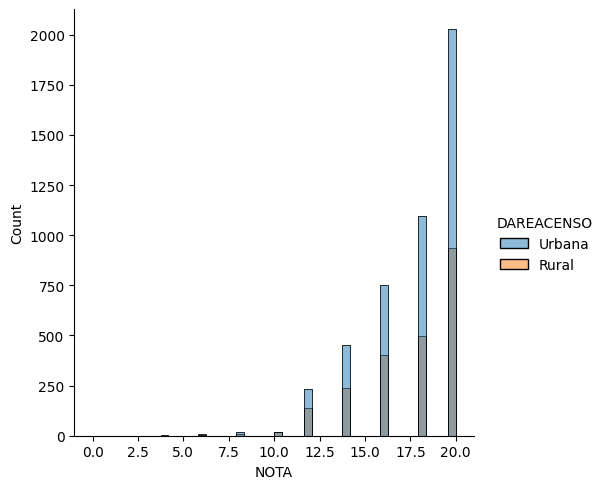

In [75]:
sns.displot(data=df_tbl_f1, x='NOTA',hue='DAREACENSO')
plt.show()

In [76]:
df_tbl_f1[df_tbl_f1['CONDICION']=='NO APROBADO']

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO,DNI,NIVEL_NEXUS,DESCRIPCION_TIPO_TRABAJADOR,ESCALA_DIFODS,SITUACION_LABORAL_DIFODS,EDAD,SEXO,DAREACENSO
11,5797872,241,894,298.0,2332152,623,216102,10.0,20.0,NO APROBADO,07451271,07451271,Secundaria,DOCENTE,7,NOMBRADO,55.0,FEMENINO,Urbana
24,5828991,238,885,271.0,2332206,623,71244,8.0,20.0,NO APROBADO,31664944,31664944,Secundaria,DOCENTE,1,NOMBRADO,50.0,FEMENINO,Rural
85,5814917,235,876,244.0,2332388,623,503268,8.0,20.0,NO APROBADO,33787976,33787976,Inicial - Jardín,DOCENTE,1,CONTRATADO,44.0,FEMENINO,Urbana
117,5802364,236,879,253.0,2332438,623,314470,8.0,20.0,NO APROBADO,20059560,20059560,Primaria,DOCENTE,1,CONTRATADO,48.0,FEMENINO,Rural
195,5803892,238,885,271.0,2332479,623,270755,10.0,20.0,NO APROBADO,04055897,04055897,Secundaria,DOCENTE,2,NOMBRADO,58.0,MASCULINO,Rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8459,5829077,241,931,376.0,2366511,623,85475,8.0,20.0,NO APROBADO,20073527,20073527,Secundaria,DOCENTE,2,NOMBRADO,48.0,FEMENINO,Urbana
8828,5812770,235,877,247.0,2356258,623,481379,10.0,20.0,NO APROBADO,16005113,16005113,Inicial - Jardín,DOCENTE,1,CONTRATADO,52.0,FEMENINO,Rural
8855,5823314,241,949,427.0,2387072,623,584733,10.0,20.0,NO APROBADO,28995464,28995464,Secundaria,DOCENTE,1,CONTRATADO,49.0,FEMENINO,Rural
8904,5825117,242,951,433.0,2383256,623,30918,10.0,20.0,NO APROBADO,02853463,02853463,Primaria,DOCENTE,5,NOMBRADO,53.0,FEMENINO,Rural


In [77]:
print(df_tbl_f1['CONDICION'].unique())
print(df_tbl_f1['NIVEL_NEXUS'].unique())
print(df_tbl_f1['DESCRIPCION_TIPO_TRABAJADOR'].unique())
print(df_tbl_f1['ESCALA_DIFODS'].unique())
print(df_tbl_f1['SITUACION_LABORAL_DIFODS'].unique())
print(df_tbl_f1['SEXO'].unique())
print(df_tbl_f1['DAREACENSO'].unique())

['APROBADO' 'NO APROBADO']
['Secundaria' 'Primaria' 'Inicial - Jardín' 'Básica Alternativa-Avanzado'
 'Inicial - Cuna-jardín' 'Básica Alternativa-Inicial e I'
 'Básica Especial-Primaria' 'Básica Especial-Inicial']
['DOCENTE']
['6' '2' '5' '1' '7' '4' '3']
['NOMBRADO' 'CONTRATADO']
['FEMENINO' 'MASCULINO']
['Urbana' 'Rural']


In [78]:
#Reclasificación de Variables
#df_tbl_f1['CONDICION'] = np.where(df_tbl_f1['CONDICION'] == 'APROBADO',1,0)

In [79]:
df.describe()

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA
count,9.096000e+03,9096.000000,9096.000000,9096.000000,9.096000e+03,9096.0,9096.000000,9096.000000,9096.0
mean,5.816153e+06,237.648197,895.406442,294.876649,2.351733e+06,623.0,331171.234389,17.595427,20.0
std,1.264740e+04,2.150373,21.855084,52.197236,1.602651e+04,0.0,189354.798629,2.757551,0.0
min,5.795769e+06,235.000000,876.000000,244.000000,2.325914e+06,623.0,199.000000,0.000000,20.0
25%,5.804753e+06,236.000000,880.000000,256.000000,2.337752e+06,623.0,164807.000000,16.000000,20.0
50%,5.815506e+06,237.000000,885.000000,271.000000,2.349578e+06,623.0,327211.500000,18.000000,20.0
75%,5.827446e+06,239.000000,897.000000,331.000000,2.364336e+06,623.0,506945.000000,20.000000,20.0
max,5.839323e+06,242.000000,951.000000,433.000000,2.395298e+06,623.0,607833.000000,20.000000,20.0


In [80]:
# Evidencia de valores duplicados
dup_df = df.groupby(['ID_CURSO','ID_GRUPO','ID_PARTICIPANTE'])['ID_PARTICIPANTE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
dup_df[dup_df['CONTEO']>1].sort_values('ID_CURSO')


,ID_CURSO,ID_GRUPO,ID_PARTICIPANTE,CONTEO


In [81]:
# Numero de duplicados por id_participante
df= df.drop_duplicates(['ID_CURSO','ID_GRUPO','ID_PARTICIPANTE'],keep='last')

In [82]:
# Numero de duplicados por id_participante
dup_participante_df = df.groupby(['ID_PARTICIPANTE'])['ID_PARTICIPANTE'].count().sort_values(ascending=False).to_frame('CONTEO').reset_index()
dup_participante_df[dup_participante_df['CONTEO']>1]

,ID_PARTICIPANTE,CONTEO


In [83]:
df.isnull().sum()

ID                     0
ID_OFERTA_FORMATIVA    0
ID_GRUPO               0
ID_CURSO               0
ID_PARTICIPANTE        0
CURID                  0
USERID                 0
NOTA                   0
NOTA_MAXIMA            0
CONDICION              0
USUARIO_DOCUMENTO      0
dtype: int64

In [84]:
df.dropna(inplace=True)

In [85]:
df.isnull().sum()

ID                     0
ID_OFERTA_FORMATIVA    0
ID_GRUPO               0
ID_CURSO               0
ID_PARTICIPANTE        0
CURID                  0
USERID                 0
NOTA                   0
NOTA_MAXIMA            0
CONDICION              0
USUARIO_DOCUMENTO      0
dtype: int64

In [86]:
df.dtypes

ID                       int64
ID_OFERTA_FORMATIVA      int64
ID_GRUPO                 int64
ID_CURSO               float64
ID_PARTICIPANTE          int64
CURID                    int64
USERID                   int64
NOTA                   float64
NOTA_MAXIMA            float64
CONDICION               object
USUARIO_DOCUMENTO       object
dtype: object

In [87]:
def grafico_codo(data_scaled):
  range_n_clusters = range(1, 11)
  inertias = []

  for n_clusters in range_n_clusters:
      modelo_kmeans = KMeans(n_clusters = n_clusters, n_init = 20, random_state = 123)
      modelo_kmeans.fit(X=data_scaled)
      inertias.append(modelo_kmeans.inertia_)

  fig, ax = plt.subplots(1, 1)
  ax.plot(range_n_clusters, inertias, marker='o')
  ax.set_title("Número Óptimo de Cluster")
  ax.set_xlabel('Número clusters')
  plt.show()

In [88]:
#Reclas caracteristicas
df['CONDICION'] = np.where(df['CONDICION']=='APROBADO',1,0)

In [89]:
df.CONDICION.unique()

array([1, 0])

In [90]:
variable = ['NOTA','CONDICION']
df_norm =  StandardScaler().fit_transform(df.loc[:,variable])


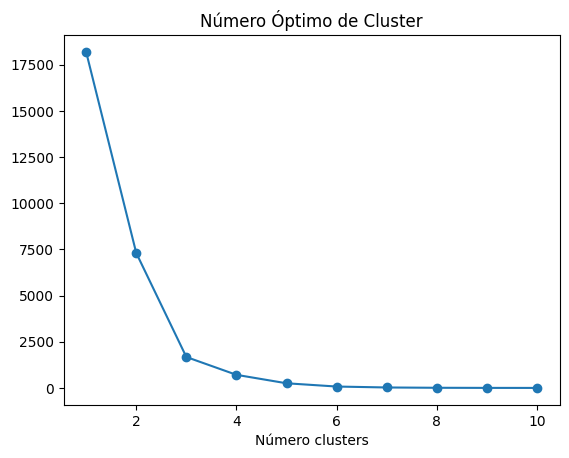

In [91]:
grafico_codo(df_norm)

In [92]:
predicted_clusters_kmeans = KMeans(n_clusters=3, random_state=1).fit_predict(X=df_norm)

c:\Users\DIFODS103\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [93]:
davies_bouldin_score_kmeans = davies_bouldin_score(df_norm, predicted_clusters_kmeans)
silhouette_score_kmeans = silhouette_score(df_norm, predicted_clusters_kmeans)
result_comp_clusters = pd.DataFrame(index=['Índice de Davies-Bouldin', 'Índice de Silhouette'])
result_comp_clusters['K-means'] = [davies_bouldin_score_kmeans, silhouette_score_kmeans]
print(result_comp_clusters)


                           K-means
Índice de Davies-Bouldin  0.367011
Índice de Silhouette      0.739544


In [94]:
df['CLUSTER'] = predicted_clusters_kmeans + 1

In [95]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

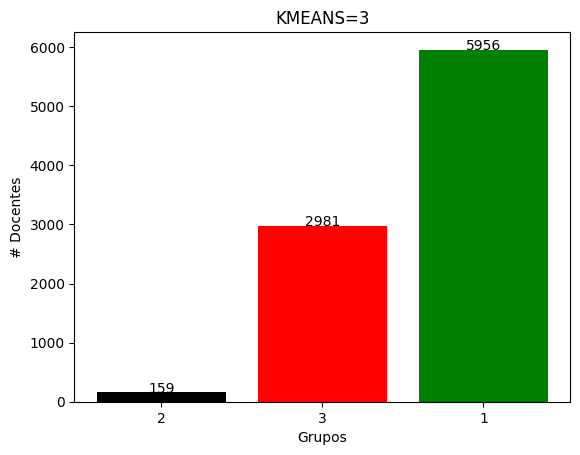

In [96]:
cluster = df.groupby('CLUSTER')['CLUSTER'].count().sort_values(ascending=True).to_frame('CONTEO').reset_index()
plt.bar(cluster['CLUSTER'].astype('str'),cluster['CONTEO'],color=['black', 'red', 'green'])
addlabels(cluster['CLUSTER'].astype('str'),cluster['CONTEO'])
plt.title("KMEANS=3")
plt.xlabel("Grupos")
plt.ylabel("# Docentes")
plt.show()

In [97]:
cluster

,CLUSTER,CONTEO
0,2,159
1,3,2981
2,1,5956


In [98]:
df[df['CLUSTER']==2].describe()

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,CLUSTER
count,1.590000e+02,159.000000,159.000000,159.000000,1.590000e+02,159.0,159.000000,159.000000,159.0,159.0,159.0
mean,5.817937e+06,237.427673,899.597484,304.660377,2.355170e+06,623.0,433853.364780,8.427673,20.0,0.0,2.0
std,1.134877e+04,2.217477,25.422038,60.918272,1.758182e+04,0.0,189663.500449,1.900896,0.0,0.0,0.0
min,5.795951e+06,235.000000,876.000000,244.000000,2.330179e+06,623.0,826.000000,0.000000,20.0,0.0,2.0
25%,5.809328e+06,235.500000,879.000000,253.000000,2.339839e+06,623.0,297813.000000,8.000000,20.0,0.0,2.0
50%,5.820284e+06,237.000000,885.000000,271.000000,2.354605e+06,623.0,497658.000000,8.000000,20.0,0.0,2.0
75%,5.826194e+06,239.000000,926.000000,361.000000,2.370168e+06,623.0,601471.000000,10.000000,20.0,0.0,2.0
max,5.839171e+06,242.000000,951.000000,433.000000,2.394685e+06,623.0,607674.000000,10.000000,20.0,0.0,2.0


In [99]:
df[df['CLUSTER']==1].describe()

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,CLUSTER
count,5.956000e+03,5956.000000,5956.000000,5956.000000,5.956000e+03,5956.0,5956.000000,5956.000000,5956.0,5956.0,5956.0
mean,5.816136e+06,237.594694,895.292646,294.381968,2.351542e+06,623.0,319081.238247,19.307253,20.0,1.0,1.0
std,1.283743e+04,2.107744,21.924222,52.300694,1.620485e+04,0.0,188636.411897,0.951708,0.0,0.0,0.0
min,5.795769e+06,235.000000,876.000000,244.000000,2.325916e+06,623.0,199.000000,18.000000,20.0,1.0,1.0
25%,5.804380e+06,236.000000,880.000000,256.000000,2.337514e+06,623.0,154087.500000,18.000000,20.0,1.0,1.0
50%,5.815612e+06,237.000000,885.000000,271.000000,2.349032e+06,623.0,307102.000000,20.000000,20.0,1.0,1.0
75%,5.827930e+06,239.000000,897.000000,331.000000,2.364349e+06,623.0,500584.750000,20.000000,20.0,1.0,1.0
max,5.839323e+06,242.000000,951.000000,433.000000,2.395298e+06,623.0,607833.000000,20.000000,20.0,1.0,1.0


In [100]:
df[df['CLUSTER']==3].describe()

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,CLUSTER
count,2.981000e+03,2981.000000,2981.000000,2981.000000,2.981000e+03,2981.0,2981.000000,2981.000000,2981.0,2981.0,2981.0
mean,5.816091e+06,237.766857,895.410265,295.343173,2.351931e+06,623.0,349850.053002,14.664207,20.0,1.0,3.0
std,1.232332e+04,2.225309,21.494476,51.445684,1.555702e+04,0.0,187648.647306,1.506682,0.0,0.0,0.0
min,5.795785e+06,235.000000,876.000000,244.000000,2.325914e+06,623.0,480.000000,12.000000,20.0,1.0,3.0
25%,5.805637e+06,236.000000,880.000000,256.000000,2.338327e+06,623.0,186651.000000,14.000000,20.0,1.0,3.0
50%,5.814997e+06,237.000000,885.000000,271.000000,2.350529e+06,623.0,360566.000000,16.000000,20.0,1.0,3.0
75%,5.826756e+06,240.000000,897.000000,331.000000,2.364092e+06,623.0,515578.000000,16.000000,20.0,1.0,3.0
max,5.839320e+06,242.000000,951.000000,433.000000,2.395269e+06,623.0,607741.000000,16.000000,20.0,1.0,3.0


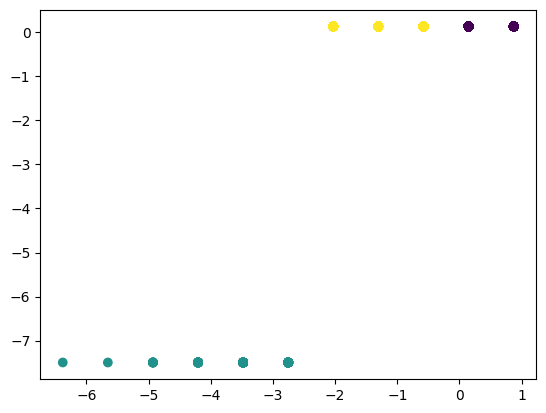

In [101]:
plt.scatter(x=df_norm[:, 0], y=df_norm[:,1],c=predicted_clusters_kmeans)
plt.show()

In [102]:
df

,ID,ID_OFERTA_FORMATIVA,ID_GRUPO,ID_CURSO,ID_PARTICIPANTE,CURID,USERID,NOTA,NOTA_MAXIMA,CONDICION,USUARIO_DOCUMENTO,CLUSTER
0,5813901,237,882,262.0,2332133,623,527383,20.0,20.0,1,43330429,1
1,5797692,238,885,271.0,2332135,623,238732,20.0,20.0,1,04339397,1
2,5829436,236,879,253.0,2332137,623,101221,14.0,20.0,1,10691343,3
3,5796789,237,882,262.0,2332141,623,198104,16.0,20.0,1,21880431,3
4,5811404,238,885,271.0,2332143,623,479627,18.0,20.0,1,17440325,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14678,5797881,239,945,415.0,2394829,623,213919,18.0,20.0,1,01334286,1
14679,5828945,238,943,409.0,2394836,623,94343,20.0,20.0,1,08687325,1
14680,5827577,237,941,403.0,2394861,623,607833,20.0,20.0,1,71323174,1
14681,5829235,235,937,391.0,2375801,623,94514,20.0,20.0,1,09959906,1
